In [1]:
!unzip /content/drive/MyDrive/Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/val/Peach___Bacterial_spot/image (1273).JPG  
  inflating: __MACOSX/Dataset/val/Peach___Bacterial_spot/._image (1273).JPG  
  inflating: Dataset/val/Peach___Bacterial_spot/image (640).JPG  
  inflating: __MACOSX/Dataset/val/Peach___Bacterial_spot/._image (640).JPG  
  inflating: Dataset/val/Peach___Bacterial_spot/image (2132).JPG  
  inflating: __MACOSX/Dataset/val/Peach___Bacterial_spot/._image (2132).JPG  
  inflating: Dataset/val/Peach___Bacterial_spot/image (2098).JPG  
  inflating: __MACOSX/Dataset/val/Peach___Bacterial_spot/._image (2098).JPG  
  inflating: Dataset/val/Peach___Bacterial_spot/image (80).JPG  
  inflating: __MACOSX/Dataset/val/Peach___Bacterial_spot/._image (80).JPG  
  inflating: Dataset/val/Peach___Bacterial_spot/image (1933).JPG  
  inflating: __MACOSX/Dataset/val/Peach___Bacterial_spot/._image (1933).JPG  
  inflating: Dataset/val/Peach___Bacterial_spot/image (494).JPG  
  inflating: __MACO

In [2]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-26ea3e5a-9acd-479d-695d-14fbe447814f)


### Import Libraries

In [3]:
import datetime
import glob
import itertools
import os
import random
import shutil

import cv2
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import display
from PIL import Image as im
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             confusion_matrix, precision_score, recall_score)
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import (BatchNormalization, Concatenate, Conv2D,
                                     Conv2DTranspose, Dropout, Input,
                                     MaxPool2D)
from tensorflow.keras.losses import (CategoricalCrossentropy,
                                     SparseCategoricalCrossentropy)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.random.seed(42)
tf.random.set_seed(42)

In [4]:
train_dir='/content/Dataset/train'
valid_dir='/content/Dataset/val'
test_dir='/content/Dataset/test'

In [5]:
train_gen = tf.keras.utils.image_dataset_from_directory(directory="/content/Dataset/train",
                                                        image_size=(256, 256),
                                                        batch_size = 32
                                                        )
val_gen = tf.keras.utils.image_dataset_from_directory(directory="/content/Dataset/val",
                                                       image_size=(256, 256),
                                                       batch_size = 32)

rescale = tf.keras.layers.Rescaling(scale=1.0/255)
train_gen = train_gen.map(lambda image,label:(rescale(image),label))
val_gen  = val_gen.map(lambda image,label:(rescale(image),label))

test_gen = tf.keras.utils.image_dataset_from_directory(directory="/content/Dataset/test",image_size=(256, 256))
test_gen  = test_gen.map(lambda image,label:(rescale(image),label))

Found 42230 files belonging to 38 classes.
Found 9042 files belonging to 38 classes.
Found 9071 files belonging to 38 classes.


### Model1: Teacher Network

In [6]:
from tensorflow.keras.applications.resnet import ResNet152

In [7]:
base_model = ResNet152(weights="imagenet",include_top=False,input_shape=(256,256,3))
print(f"Network Length:{len(base_model.layers)}")

for layer in base_model.layers:
  layer.trainable = False

x = layers.Flatten()(base_model.output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(38, activation="softmax")(x)
teacher_model = Model(inputs=base_model.input,outputs= x) #linear activation to get pre-soft logits

opt = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.001)
teacher_model.compile(optimizer=opt,
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

teacher_model.summary()

234708992/234698864 [==============================] - 4s 0us/step
Network Length:515
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
        

**Extracted Parameters = 125 Million parameters**

In [8]:
# !mkdir /content/drive/MyDrive/KnowDist
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
filepath="/content/drive/MyDrive/Colab Notebooks/Knowledge Distillation/resnetmodel/weights-teacher_model(resnet152)_15th.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks = [earlystop,checkpoint]

### Train Model

In [9]:
History = teacher_model.fit(train_gen,
                            validation_data=val_gen,
                            epochs=10,
                            shuffle=True,
                            callbacks=callbacks,
                            use_multiprocessing=True, 
                            workers=10,
                            )

Epoch 1/10
1320/1320 [==============================] - ETA: 0s - loss: 1.8437 - accuracy: 0.5112
Epoch 1: val_loss improved from inf to 3.89510, saving model to /content/drive/MyDrive/Colab Notebooks/Knowledge Distillation/resnetmodel/weights-teacher_model(resnet152)_15th.hdf5
1320/1320 [==============================] - 288s 204ms/step - loss: 1.8437 - accuracy: 0.5112 - val_loss: 3.8951 - val_accuracy: 0.2110
Epoch 2/10
1320/1320 [==============================] - ETA: 0s - loss: 1.2801 - accuracy: 0.6512
Epoch 2: val_loss improved from 3.89510 to 2.14886, saving model to /content/drive/MyDrive/Colab Notebooks/Knowledge Distillation/resnetmodel/weights-teacher_model(resnet152)_15th.hdf5
1320/1320 [==============================] - 269s 204ms/step - loss: 1.2801 - accuracy: 0.6512 - val_loss: 2.1489 - val_accuracy: 0.4121
Epoch 3/10
1320/1320 [==============================] - ETA: 0s - loss: 1.0644 - accuracy: 0.7110
Epoch 3: val_loss improved from 2.14886 to 1.47369, saving model t

### Load best teacher model weight and save the model

In [10]:
teacher_model.load_weights("/content/drive/MyDrive/Colab Notebooks/Knowledge Distillation/resnetmodel/weights-teacher_model(resnet152)_15th.hdf5")
teacher_model.save("/content/drive/MyDrive/Colab Notebooks/Knowledge Distillation/resnetmodel/Resnet152_15th/")

### Print Model Statistics

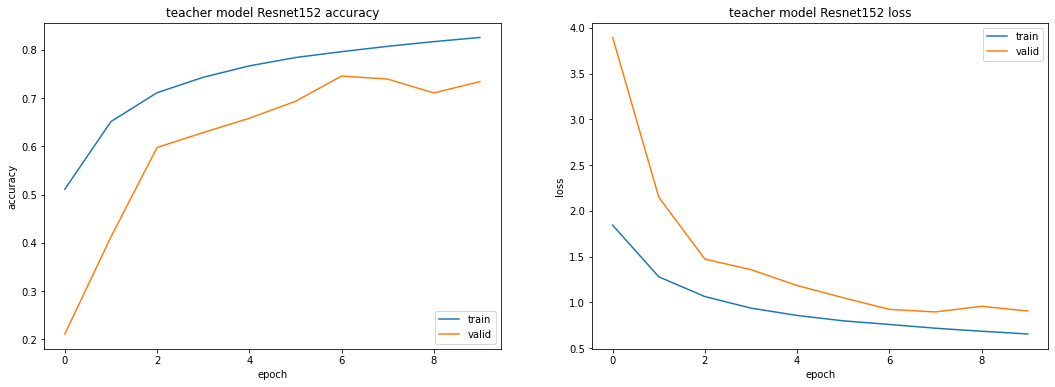

In [11]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(18,6))  
# summarize history for accuracy
plt.subplot(121)
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('teacher model Resnet152 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
 # summarize history for loss
plt.subplot(122)
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('teacher model Resnet152 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [12]:
print(teacher_model.metrics_names) 
loss, acc = teacher_model.evaluate(val_gen, verbose = 1)
print('test loss = ', loss) 
print('test accuracy = ',acc)

['loss', 'accuracy']
283/283 [==============================] - 46s 162ms/step - loss: 0.8967 - accuracy: 0.7393
test loss =  0.8966811299324036
test accuracy =  0.739327609539032


In [13]:
from tqdm import tqdm
labels = []
predictions = []
for x,y in tqdm(val_gen):
    labels.append(list(y.numpy()))
    predictions.append(tf.argmax(teacher_model.predict(x),1).numpy())

100%|██████████| 283/283 [01:02<00:00,  4.49it/s]


In [14]:
predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))

### Teacher Model Performance

In [15]:
from sklearn.metrics import classification_report,cohen_kappa_score,matthews_corrcoef
print(f"Model: Teacher Model(Resnet152) \n")
print(classification_report(labels, predictions))

cohen_kappa_score = cohen_kappa_score(labels, predictions)
Metthews_correlation = matthews_corrcoef(labels, predictions)

print("Cohen Kappa Score: ", cohen_kappa_score)
print("Matthews correlation coefficient : ", Metthews_correlation)

Model: Teacher Model(Resnet152) 

              precision    recall  f1-score   support

           0       0.56      0.15      0.24       150
           1       0.41      0.89      0.57       150
           2       0.70      0.56      0.62       150
           3       0.81      0.52      0.64       246
           4       0.96      0.66      0.78       225
           5       0.89      0.78      0.83       157
           6       0.97      0.47      0.63       150
           7       0.71      0.50      0.59       150
           8       0.92      0.96      0.94       178
           9       0.63      0.75      0.68       150
          10       0.84      0.91      0.87       174
          11       0.80      0.62      0.70       177
          12       0.76      0.80      0.78       207
          13       0.86      0.89      0.88       161
          14       0.82      0.85      0.83       150
          15       0.80      0.99      0.88       826
          16       0.47      0.92      0.63    

Teacher Model(Resnet152) : Confusion Matrix


<Figure size 1440x360 with 0 Axes>

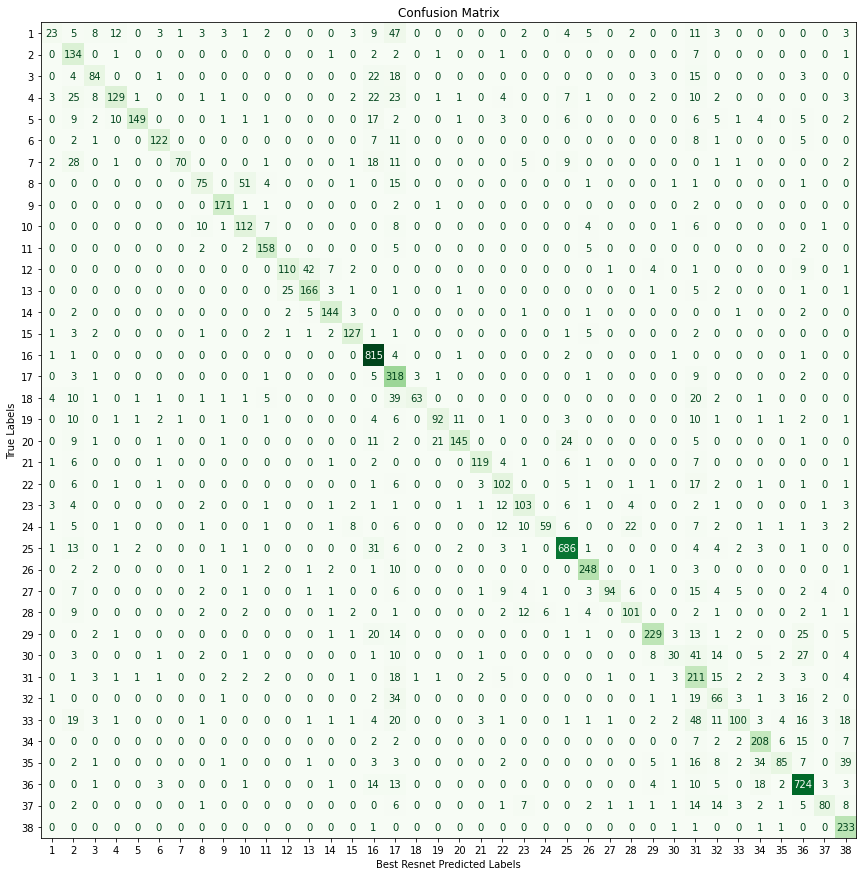

In [16]:
print("Teacher Model(Resnet152) : Confusion Matrix")

plt.figure(figsize= (20,5))
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(1,39)))
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,colorbar= False,cmap = 'Greens')
plt.title("Confusion Matrix")
plt.xlabel('Best Resnet Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Model2:Student Model

In [17]:
# del model
input = Input(shape=(256,256,3))
# Layer:1 
x = tf.keras.layers.Conv2D(16,(3,3),activation="relu",padding="same")(input)
x = tf.keras.layers.Conv2D(16,(3,3),activation="relu",padding="same")(x)
x = tf.keras.layers.MaxPooling2D(3,3)(x)
# Layer:2
x = tf.keras.layers.Conv2D(32,(3,3),activation="relu",padding="same")(x)
x = tf.keras.layers.Conv2D(32,(3,3),activation="relu",padding="same")(x)
x = tf.keras.layers.MaxPooling2D(3,3)(x)
# Layer:3
x = tf.keras.layers.Conv2D(64,(3,3),activation="relu",padding="same")(x)
x = tf.keras.layers.Conv2D(64,(3,3),activation="relu",padding="same")(x)
x = tf.keras.layers.MaxPooling2D(3,3)(x)
# Layer:4
x = tf.keras.layers.Conv2D(128,(3,3),activation="relu",padding="same")(x)
x = tf.keras.layers.Conv2D(128,(3,3),activation="relu",padding="same")(x)
# Layer:5
x = tf.keras.layers.Conv2D(256,(5,5),activation="relu",padding="same")(x)
x = tf.keras.layers.Conv2D(256,(5,5),activation="relu",padding="same")(x)
# Layer:6
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512,activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)

output = tf.keras.layers.Dense(38,activation="softmax")(x)

student_model = tf.keras.Model(inputs = input, outputs = output, name="student_model")
student_model.compile(optimizer=opt,
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])
student_model.summary()

Model: "student_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 85, 85, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 85, 85, 32)        9248      
                                                     

In [18]:
# Clone student for later comparison
student_scratch = tf.keras.models.clone_model(student_model)

### Distiller Class

In [19]:
class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.5,
        temperature=2,
    ):
        """ Configure the distiller.
        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature
        
    def train_step(self, data):
        # Unpack data
        x, y = data
        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)
        #model = ...  # create the original model
        teacher_predictions = self.teacher(x, training=False)
        with tf.GradientTape() as tape:
            # Forward pass of student
            # Forward pass of student
            student_predictions = self.student(x, training=True)
            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss +  distillation_loss
        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)
        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results
    def test_step(self, data):
        # Unpack the data
        x, y = data
        # Compute predictions
        y_prediction = self.student(x, training=False)
        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)
        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [20]:
dist_earlystop = EarlyStopping(monitor='distillation_loss', patience=5, verbose=1)
# filepath="/content/drive/MyDrive/KnowDist/weights-distil.h5"
# dist_checkpoint = ModelCheckpoint(filepath=filepath, monitor='distillation_loss', verbose=1, save_best_only=True, mode='min')
dist_callbacks = [dist_earlystop]

### DistillerModel trained on Temprature = 2

In [28]:
# Initialize and compile distiller
# del distiller
distiller = Distiller(student=student_model, teacher=teacher_model)
distiller.compile(optimizer=Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.001),
                  metrics=['accuracy'],
                  student_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  distillation_loss_fn=tf.keras.losses.KLDivergence(),
                  alpha=0.5,
                  temperature=3)

# Distill teacher to student
distiller_hist = distiller.fit(train_gen, 
                               validation_data = val_gen, 
                               epochs=10,
                               shuffle=True,
                               callbacks = dist_callbacks,
                               use_multiprocessing=True,
                               workers = 10
                               )

Epoch 1/10
1320/1320 [==============================] - 264s 195ms/step - accuracy: 0.8769 - student_loss: 0.3837 - distillation_loss: 3.9460e-04 - val_accuracy: 0.9162 - val_student_loss: 0.5891
Epoch 2/10
1320/1320 [==============================] - 257s 195ms/step - accuracy: 0.9115 - student_loss: 0.2726 - distillation_loss: 3.9453e-04 - val_accuracy: 0.9257 - val_student_loss: 0.2414
Epoch 3/10
1320/1320 [==============================] - 257s 195ms/step - accuracy: 0.9256 - student_loss: 0.2277 - distillation_loss: 3.9426e-04 - val_accuracy: 0.9395 - val_student_loss: 0.0937
Epoch 4/10
1320/1320 [==============================] - 257s 195ms/step - accuracy: 0.9384 - student_loss: 0.1915 - distillation_loss: 4.0064e-04 - val_accuracy: 0.9433 - val_student_loss: 0.0318
Epoch 5/10
1320/1320 [==============================] - 257s 195ms/step - accuracy: 0.9455 - student_loss: 0.1673 - distillation_loss: 4.0278e-04 - val_accuracy: 0.9447 - val_student_loss: 0.1323
Epoch 6/10
1320/1320

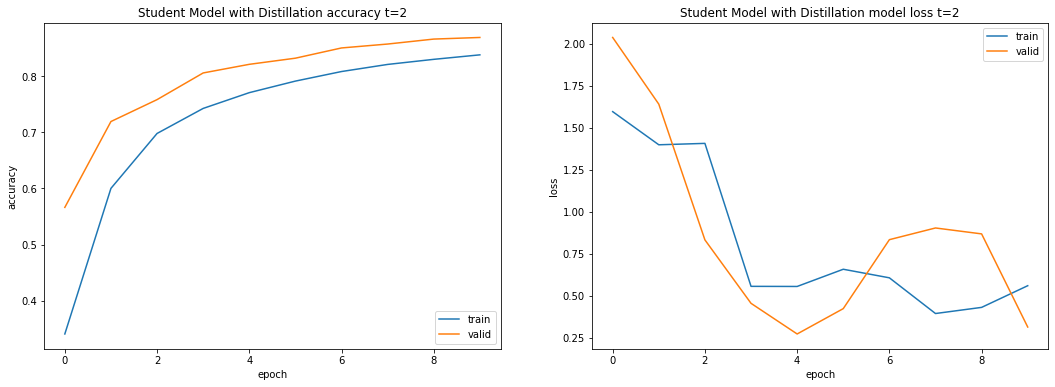

In [22]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(18,6))  
# summarize history for accuracy
plt.subplot(121)
plt.plot(distiller_hist.history['accuracy'])
plt.plot(distiller_hist.history['val_accuracy'])
plt.title('Student Model with Distillation accuracy t=5')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
 # summarize history for loss
plt.subplot(122)
plt.plot(distiller_hist.history['student_loss'])
plt.plot(distiller_hist.history['val_student_loss'])
plt.title('Student Model with Distillation model loss t=5')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [23]:
print(distiller.metrics_names)
acc, loss = distiller.evaluate(val_gen, verbose = 1) 
print('test loss = ', loss)
print('test accuracy = ',acc)

['accuracy']
283/283 [==============================] - 6s 22ms/step - accuracy: 0.8692 - student_loss: 0.4146
test loss =  0.3391161561012268
test accuracy =  0.8691661357879639


### DistillerModel trained on Temprature = 6

In [29]:
# Initialize and compile distiller
# del distiller
distiller = Distiller(student=student_model, teacher=teacher_model)
distiller.compile(optimizer=Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.001),
                  metrics=['accuracy'],
                  student_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  distillation_loss_fn=tf.keras.losses.KLDivergence(),
                  alpha=0.6,
                  temperature=6)

# Distill teacher to student
distiller_hist = distiller.fit(train_gen, 
                               validation_data = val_gen, 
                               epochs=10,
                               shuffle=True,
                               callbacks = dist_callbacks,
                               use_multiprocessing=True,
                               workers = 10
                               )

Epoch 1/10
1320/1320 [==============================] - 266s 195ms/step - accuracy: 0.9193 - student_loss: 0.2452 - distillation_loss: 9.5882e-05 - val_accuracy: 0.9161 - val_student_loss: 0.1467
Epoch 2/10
1320/1320 [==============================] - 258s 195ms/step - accuracy: 0.9480 - student_loss: 0.1595 - distillation_loss: 9.5119e-05 - val_accuracy: 0.9491 - val_student_loss: 0.2654
Epoch 3/10
1320/1320 [==============================] - 258s 196ms/step - accuracy: 0.9570 - student_loss: 0.1272 - distillation_loss: 9.6759e-05 - val_accuracy: 0.9503 - val_student_loss: 0.1102
Epoch 4/10
1320/1320 [==============================] - 258s 195ms/step - accuracy: 0.9650 - student_loss: 0.1039 - distillation_loss: 9.7883e-05 - val_accuracy: 0.9490 - val_student_loss: 0.2238
Epoch 5/10
1320/1320 [==============================] - 258s 195ms/step - accuracy: 0.9691 - student_loss: 0.0929 - distillation_loss: 9.8400e-05 - val_accuracy: 0.9558 - val_student_loss: 0.0405
Epoch 6/10
1320/1320

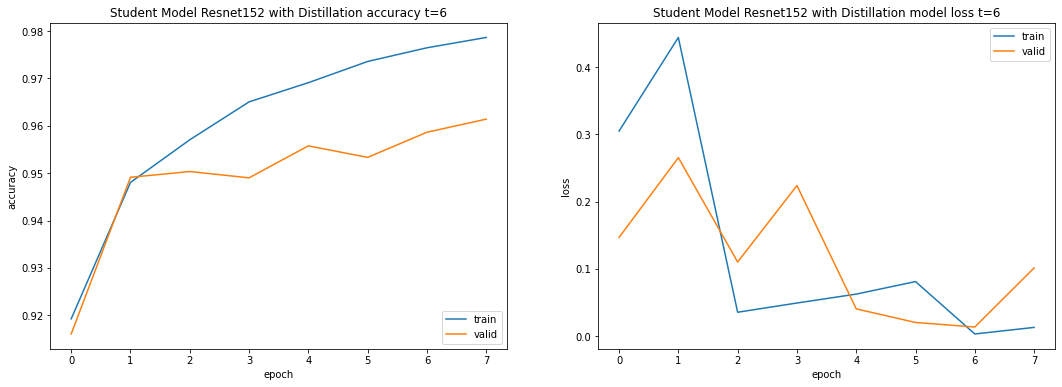

In [30]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(18,6))  
# summarize history for accuracy
plt.subplot(121)
plt.plot(distiller_hist.history['accuracy'])
plt.plot(distiller_hist.history['val_accuracy'])
plt.title('Student Model Resnet152 with Distillation accuracy t=6')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
 # summarize history for loss
plt.subplot(122)
plt.plot(distiller_hist.history['student_loss'])
plt.plot(distiller_hist.history['val_student_loss'])
plt.title('Student Model Resnet152 with Distillation model loss t=6')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [31]:
print(distiller.metrics_names)
acc, loss = distiller.evaluate(val_gen, verbose = 1) 
print('test loss = ', loss)
print('test accuracy = ',acc)

['accuracy']
283/283 [==============================] - 6s 22ms/step - accuracy: 0.9614 - student_loss: 0.1246
test loss =  0.10720392316579819
test accuracy =  0.9614023566246033


In [32]:
student_model.save("/content/drive/MyDrive/Colab Notebooks/Knowledge Distillation/resnetmodel/Resnet152_CNN_distilation_15th.hdf5")

In [33]:
from tqdm import tqdm
labels = []
predictions = []
for x,y in tqdm(val_gen):
    labels.append(list(y.numpy()))
    predictions.append(tf.argmax(student_model.predict(x),1).numpy())

100%|██████████| 283/283 [00:18<00:00, 15.14it/s]


In [34]:
predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))

### Distiller Model Performance

Model Resnet152 : Distiller Model 

              precision    recall  f1-score   support

           0       0.95      0.85      0.90       150
           1       0.99      0.95      0.97       150
           2       0.97      0.98      0.98       150
           3       0.92      0.96      0.94       246
           4       0.96      0.97      0.96       225
           5       0.95      1.00      0.98       157
           6       0.98      0.92      0.95       150
           7       0.82      0.95      0.88       150
           8       1.00      0.98      0.99       178
           9       0.93      0.79      0.85       150
          10       1.00      0.99      1.00       174
          11       0.96      0.97      0.97       177
          12       0.98      0.98      0.98       207
          13       1.00      0.99      1.00       161
          14       0.97      0.97      0.97       150
          15       1.00      1.00      1.00       826
          16       0.99      0.96      0.97  

<Figure size 1440x360 with 0 Axes>

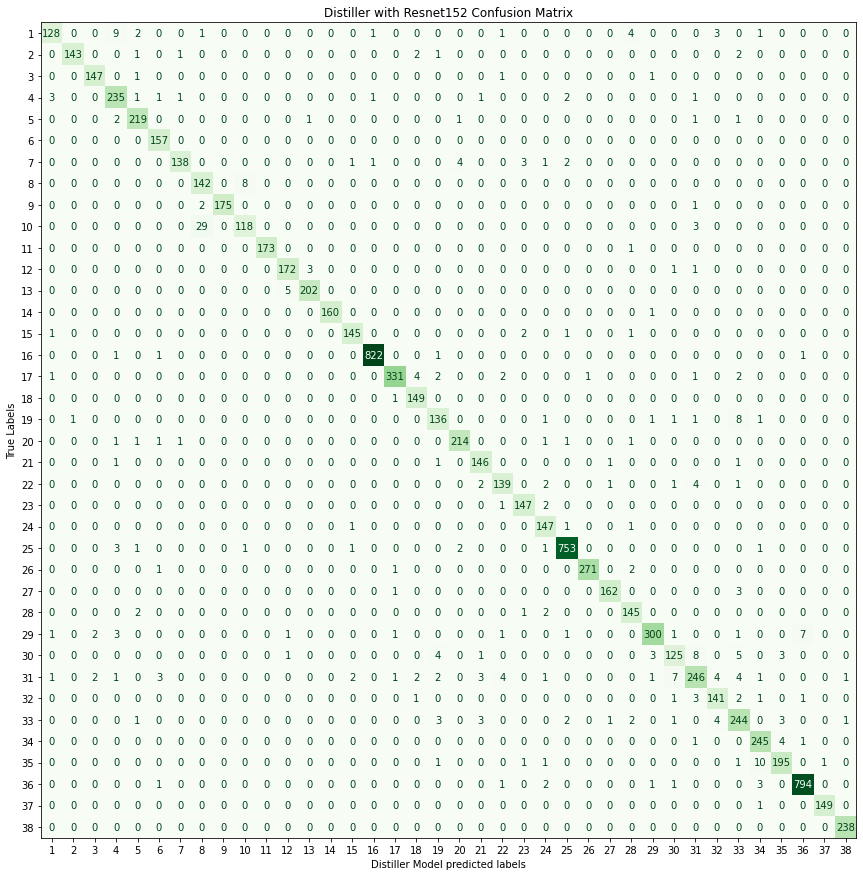

In [35]:
from sklearn.metrics import classification_report,cohen_kappa_score,matthews_corrcoef
print(f"Model Resnet152 : Distiller Model \n")
print(classification_report(labels, predictions))

cohen_kappa_score = cohen_kappa_score(labels, predictions)
Metthews_correlation = matthews_corrcoef(labels, predictions)

print("Cohen Kappa Score: ", cohen_kappa_score)
print("Matthews correlation coefficient : ", Metthews_correlation)

print("Distiller Model with Resnet152 : Confusion Matrix")

plt.figure(figsize= (20,5))
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(1,39)))
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,colorbar= False,cmap = 'Greens')
plt.title("Distiller with Resnet152 Confusion Matrix")
plt.xlabel('Distiller Model predicted labels')
plt.ylabel('True Labels')
plt.show()

### Train Student Model without Knowledge Distillation

In [ ]:
stu_earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
filepath="/content/drive/MyDrive/Colab Notebooks/Knowledge Distillation/resnetmodel/weights-student_model.hdf5"
stu_checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
stu_callbacks = [stu_earlystop,stu_checkpoint]

In [ ]:
# Train student as doen usually
student_scratch.compile(optimizer=opt,
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])
stu_history = student_scratch.fit(train_gen,
                            validation_data=val_gen,
                            epochs=10,
                            shuffle=True,
                            callbacks=stu_callbacks,
                            use_multiprocessing=True, 
                            workers=10,
                            )

Epoch 1/5
1319/1320 [============================>.] - ETA: 0s - loss: 2.8538 - accuracy: 0.2323
Epoch 1: val_loss improved from inf to 2.39831, saving model to /content/drive/MyDrive/KnowDist/weights-student_model.hdf5
1320/1320 [==============================] - 64s 48ms/step - loss: 2.8536 - accuracy: 0.2324 - val_loss: 2.3983 - val_accuracy: 0.3451
Epoch 2/5
1319/1320 [============================>.] - ETA: 0s - loss: 2.3694 - accuracy: 0.3517
Epoch 2: val_loss improved from 2.39831 to 2.05144, saving model to /content/drive/MyDrive/KnowDist/weights-student_model.hdf5
1320/1320 [==============================] - 65s 49ms/step - loss: 2.3694 - accuracy: 0.3516 - val_loss: 2.0514 - val_accuracy: 0.4396
Epoch 3/5
1320/1320 [==============================] - ETA: 0s - loss: 2.0819 - accuracy: 0.4209
Epoch 3: val_loss improved from 2.05144 to 1.76018, saving model to /content/drive/MyDrive/KnowDist/weights-student_model.hdf5
1320/1320 [==============================] - 65s 49ms/step - l

In [ ]:
student_scratch.load_weights("/content/drive/MyDrive/Colab Notebooks/Knowledge Distillation/resnetmodel/weights-student_model.hdf5")
student_scratch.save("/content/drive/MyDrive/Colab Notebooks/Knowledge Distillation/resnetmodel/Student Model")

### Print Student Model Statistics

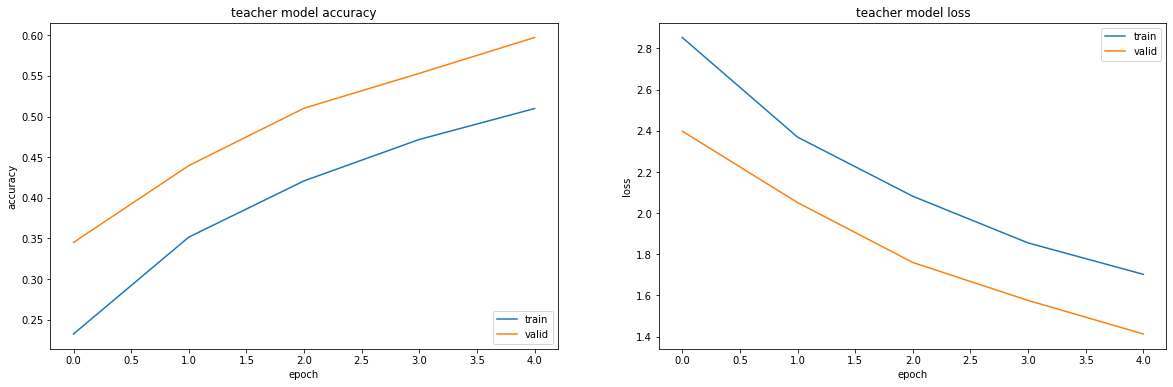

In [ ]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,6))  
# summarize history for accuracy
plt.subplot(121)
plt.plot(stu_history.history['accuracy'])
plt.plot(stu_history.history['val_accuracy'])
plt.title('teacher model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
 # summarize history for loss
plt.subplot(122)
plt.plot(stu_history.history['loss'])
plt.plot(stu_history.history['val_loss'])
plt.title('teacher model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [ ]:
print(student_model.metrics_names) 
loss, acc = student_model.evaluate(val_gen, verbose = 1)
print('test loss = ', loss) 
print('test accuracy = ',acc)

['loss', 'accuracy']
283/283 [==============================] - 6s 21ms/step - loss: 1.4128 - accuracy: 0.5973
test loss =  1.4127715826034546
test accuracy =  0.5973235964775085


In [ ]:
from tqdm import tqdm
labels = []
predictions = []
for x,y in tqdm(val_gen):
    labels.append(list(y.numpy()))
    predictions.append(tf.argmax(student_model.predict(x),1).numpy())

100%|██████████| 283/283 [00:21<00:00, 12.90it/s]


In [ ]:
predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))

### Student Model Performance

Model Best : Teacher Model 

              precision    recall  f1-score   support

           0       0.44      0.03      0.05       150
           1       0.45      0.30      0.36       150
           2       0.38      0.26      0.31       150
           3       0.61      0.72      0.66       246
           4       0.31      0.58      0.40       225
           5       0.45      0.11      0.17       157
           6       0.48      0.53      0.50       150
           7       0.34      0.29      0.32       150
           8       0.86      0.89      0.87       178
           9       0.54      0.51      0.52       150
          10       0.85      0.71      0.77       174
          11       0.45      0.49      0.47       177
          12       0.47      0.63      0.54       207
          13       0.51      0.58      0.54       161
          14       0.55      0.51      0.53       150
          15       0.80      0.92      0.86       826
          16       0.55      0.62      0.58       34

<Figure size 1440x360 with 0 Axes>

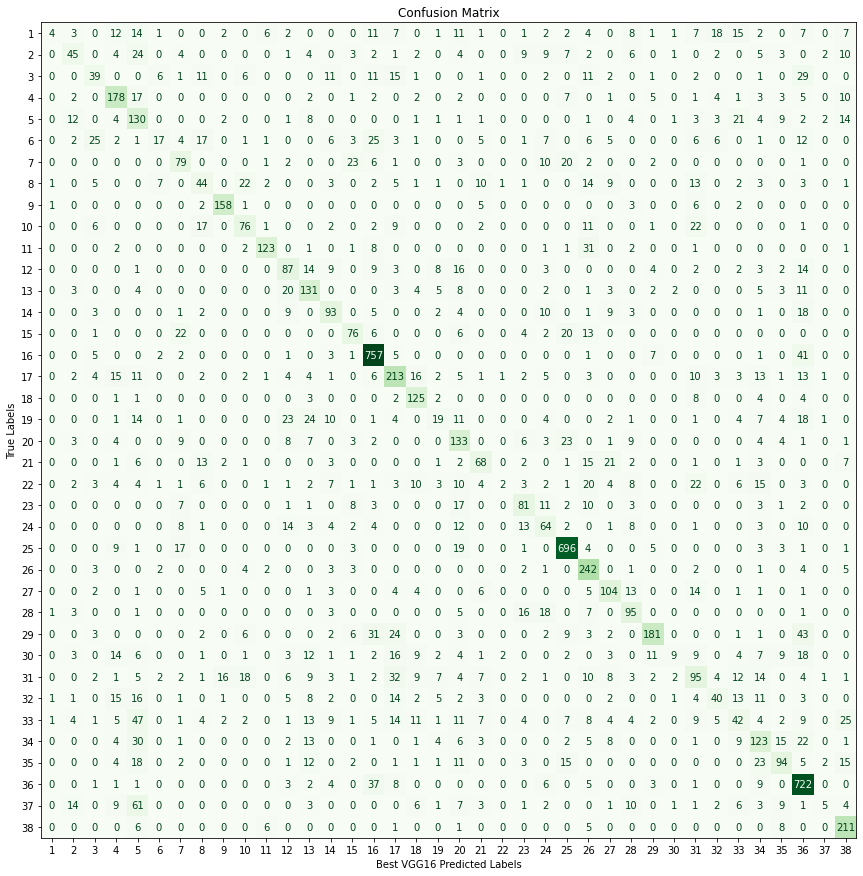

In [ ]:
from sklearn.metrics import classification_report,cohen_kappa_score,matthews_corrcoef
print(f"Model Best : Teacher Model \n")
print(classification_report(labels, predictions))

cohen_kappa_score = cohen_kappa_score(labels, predictions)
Metthews_correlation = matthews_corrcoef(labels, predictions)

print("Cohen Kappa Score: ", cohen_kappa_score)
print("Matthews correlation coefficient : ", Metthews_correlation)

print("student Model : Confusion Matrix")

plt.figure(figsize= (20,5))
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(1,39)))
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,colorbar= False,cmap = 'Greens')
plt.title("Confusion Matrix")
plt.xlabel('CNN Predicted Labels')
plt.ylabel('True Labels')
plt.show()

| Sr.No | Model Name | Parameters | HyperParameter |Test Accuracy(%)(10 epochs)                                                         |
| ----- | ----- |-------------------------------------------- | -------| ------------------------------------------------------------ |
| 1     | Teacher Model(Resnet152) | 125M| - | 73.93 |
| 2     | Student Model with Distillation| 13M |α = 0.5, t = 2 | 92.43 |
| 3     | Student Model with Distillation| 13M |α = 0.6, t = 3 | 95.13 |
| 4     | Student Model with Distillation| 13M | α = 0.6, t = 6 | 96.14 |
| 5     | Student Model without Distillation | 13M |- | 59.73 |